# SETUP

In [1]:
import os
os.getcwd()
os.chdir("..")

In [2]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from kneed import KneeLocator
from plotnine import *
from ttictoc import tic,toc

In [3]:
from src.visualization.visualize import highlight_elbow_row, draw_line_plot_for_each_k

In [4]:
pd.options.display.max_rows = 10
pd.options.display.max_columns = 999999

# Data load

In [5]:
df = pd.read_pickle('data/processed/marketing_campaign_post_feature_engineering_and_cleaning.pickle')

In [6]:
df_scaled = pd.read_pickle('data/processed/marketing_campaign_scaled_date_for_modelling.pickle')

# K-means 

## Analysis of errors for selected k

In [7]:
df_sse = pd.DataFrame({"nb_clusters": list(range(1, 11))})

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42
}

for k in df_sse.nb_clusters:
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs).fit(df_scaled)
    df_sse.loc[k - 1, 'sse'] = kmeans.inertia_
    if k > 1:
        df_sse.loc[k - 1, 'dbs'] = davies_bouldin_score(df_scaled, kmeans.labels_)
        df_sse.loc[k - 1, 'silhouette'] = silhouette_score(df_scaled, kmeans.labels_)

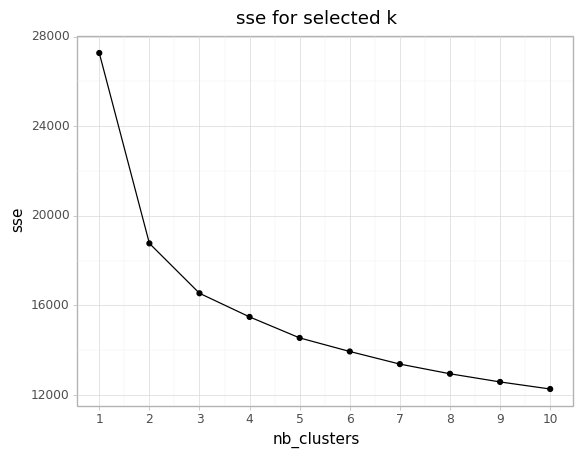

<ggplot: (130907409619)>

In [8]:
draw_line_plot_for_each_k(df_sse, "nb_clusters", "sse")

C:\Users\Winter\anaconda3\envs\customer-segmentation\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
C:\Users\Winter\anaconda3\envs\customer-segmentation\lib\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


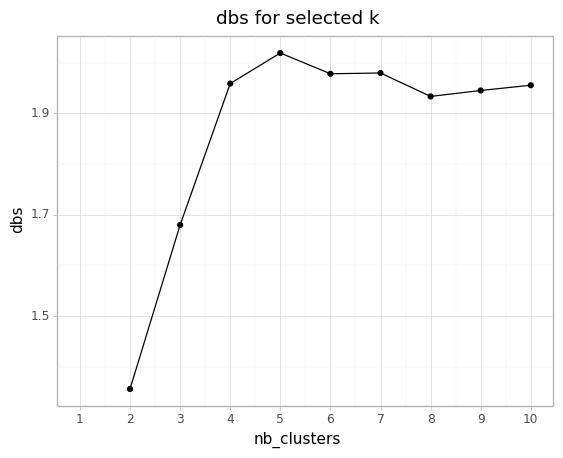

<ggplot: (130907753141)>

In [9]:
draw_line_plot_for_each_k(df_sse, "nb_clusters", "dbs")

C:\Users\Winter\anaconda3\envs\customer-segmentation\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
C:\Users\Winter\anaconda3\envs\customer-segmentation\lib\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


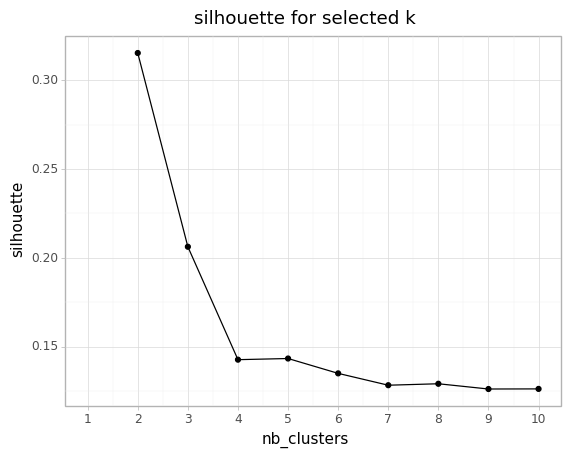

<ggplot: (130907550368)>

In [10]:
draw_line_plot_for_each_k(df_sse, "nb_clusters", "silhouette")

## Elbow detection

In [11]:
kl = KneeLocator(df_sse.nb_clusters, df_sse.sse, curve = "convex", direction = "decreasing")
kl.elbow

3

In [12]:
df_sse.style.apply(highlight_elbow_row, elbow = kl.elbow, column = 'nb_clusters', axis=1)

,nb_clusters,sse,dbs,silhouette
0,1,27263.881797,nan,nan
1,2,18767.576625,1.356199,0.315317
2,3,16540.754080,1.679871,0.206245
3,4,15485.708360,1.958821,0.142672
4,5,14548.450660,2.019114,0.143323
5,6,13942.825366,1.978167,0.134963
6,7,13379.807703,1.979692,0.128293
7,8,12948.049799,1.933429,0.129113
8,9,12583.794255,1.945216,0.126156
9,10,12268.152145,1.955536,0.126221


## Check if clusters initiation would improve results

In [13]:
kmeans_kwargs_initiated = {
    "init": "k-means++",
    "max_iter": 300
}

for k in list([kl.elbow, kl.elbow + 1]):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs_initiated).fit(df_scaled)
    df_sse.loc[k - 1, 'sse_centers_init'] = kmeans.inertia_
    if k > 1:
        df_sse.loc[k - 1, 'dbs_centers_init'] = davies_bouldin_score(df_scaled, kmeans.labels_)
        df_sse.loc[k - 1, 'silhouette_centers_init'] = silhouette_score(df_scaled, kmeans.labels_)

In [14]:
final_nb_clusters = kl.elbow
df_sse.style.apply(highlight_elbow_row, elbow = final_nb_clusters, column = 'nb_clusters', axis=1)

,nb_clusters,sse,dbs,silhouette,sse_centers_init,dbs_centers_init,silhouette_centers_init
0,1,27263.881797,nan,nan,nan,nan,nan
1,2,18767.576625,1.356199,0.315317,nan,nan,nan
2,3,16540.754080,1.679871,0.206245,16540.754080,1.679871,0.206245
3,4,15485.708360,1.958821,0.142672,14847.060926,1.272948,0.208137
4,5,14548.450660,2.019114,0.143323,nan,nan,nan
5,6,13942.825366,1.978167,0.134963,nan,nan,nan
6,7,13379.807703,1.979692,0.128293,nan,nan,nan
7,8,12948.049799,1.933429,0.129113,nan,nan,nan
8,9,12583.794255,1.945216,0.126156,nan,nan,nan
9,10,12268.152145,1.955536,0.126221,nan,nan,nan


## Hierarchical clustering to initialize clusters

### IMPORTANT!: can be used only for small datasets!

Initial clusters computations using hierarchical clustering results

In [15]:
cluster_initials = df_scaled.copy()
hierarchical_clust = AgglomerativeClustering(n_clusters = final_nb_clusters).fit(cluster_initials)

cluster_initials["hierarchical_cluster"] = hierarchical_clust.fit_predict(cluster_initials)
cluster_initials = cluster_initials.groupby(['hierarchical_cluster'], as_index=False, sort=False).mean()
cluster_initials = cluster_initials.drop("hierarchical_cluster", axis = 1)
cluster_initials

,age,tenure_days,recency,income_per_person,total_spendings,total_spendings_per_person,total_spendings_per_purchase,numwebvisitsmonth,total_purchases,spendings_to_income,is_parent,nb_family_members,wines_share,fruits_share,meat_share,fish_share,sweets_share,gold_products_share,pct_deals_purchases,pct_web_purchasess,pct_catalog_purchases,pct_store_purchases,complain,response,nb_accepted_campaigns,marital_status_cleaned,education_cleaned
0,0.093201,-0.047650,0.037080,1.461240,1.344407,1.504655,1.347699,-1.125485,0.877263,0.599483,0.069530,1.623722,0.445040,0.047305,0.333430,0.069737,0.049144,0.055344,0.064668,0.258783,0.312871,0.428346,0.004090,0.329243,0.828221,0.451943,0.077710
1,-0.130050,-0.056789,-0.013188,-0.559600,-0.737419,-0.614851,-0.665180,0.472571,-0.720446,-0.347476,0.887739,2.926752,0.419883,0.053085,0.235279,0.078358,0.053762,0.159633,0.350839,0.354297,0.089992,0.555712,0.011146,0.095541,0.088376,0.337580,0.143312
2,0.242821,0.195110,-0.003234,-0.024101,0.554192,0.075210,0.363797,-0.089045,0.981234,0.295429,0.925773,2.734021,0.573317,0.041535,0.202690,0.054959,0.044522,0.082978,0.166388,0.338130,0.208626,0.453244,0.010309,0.105155,0.307216,0.294845,0.080412


In [16]:
kmeans_clust_init_hier = KMeans(n_clusters  = final_nb_clusters, init = cluster_initials.to_numpy(), n_init = 1, max_iter = 300).fit(df_scaled)

df_sse.loc[final_nb_clusters - 1, 'sse_centers_init_hier'] = kmeans_clust_init_hier.inertia_
df_sse.loc[final_nb_clusters - 1, 'dbs_centers_init_hier'] = davies_bouldin_score(df_scaled, kmeans_clust_init_hier.labels_)
df_sse.loc[final_nb_clusters - 1, 'silhouette_centers_init_hier'] = silhouette_score(df_scaled, kmeans_clust_init_hier.labels_)

In [17]:
df_sse.style.apply(highlight_elbow_row, elbow = final_nb_clusters, column = 'nb_clusters', axis=1)

,nb_clusters,sse,dbs,silhouette,sse_centers_init,dbs_centers_init,silhouette_centers_init,sse_centers_init_hier,dbs_centers_init_hier,silhouette_centers_init_hier
0,1,27263.881797,nan,nan,nan,nan,nan,nan,nan,nan
1,2,18767.576625,1.356199,0.315317,nan,nan,nan,nan,nan,nan
2,3,16540.754080,1.679871,0.206245,16540.754080,1.679871,0.206245,16540.659248,1.681459,0.205852
3,4,15485.708360,1.958821,0.142672,14847.060926,1.272948,0.208137,nan,nan,nan
4,5,14548.450660,2.019114,0.143323,nan,nan,nan,nan,nan,nan
5,6,13942.825366,1.978167,0.134963,nan,nan,nan,nan,nan,nan
6,7,13379.807703,1.979692,0.128293,nan,nan,nan,nan,nan,nan
7,8,12948.049799,1.933429,0.129113,nan,nan,nan,nan,nan,nan
8,9,12583.794255,1.945216,0.126156,nan,nan,nan,nan,nan,nan
9,10,12268.152145,1.955536,0.126221,nan,nan,nan,nan,nan,nan


Adding cluster variable to core dataset

In [18]:
df["cluster_kmeans"] = kmeans_clust_init_hier.fit_predict(df_scaled)
df["cluster_kmeans"] = df["cluster_kmeans"].astype("category")
df.to_pickle('data/processed/marketing_campaign_with_clusters.pickle')

Clusters distribution check

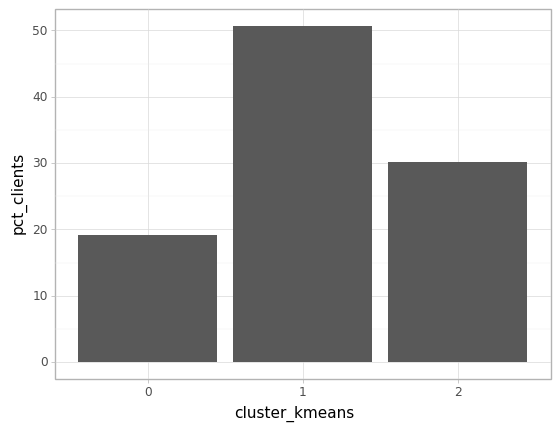

<ggplot: (130907802317)>

In [19]:
tb_cluster_counts = pd.DataFrame(df["cluster_kmeans"].value_counts() / df.shape[0] * 100).reset_index()
tb_cluster_counts.columns = ["cluster_kmeans", "pct_clients"]

(ggplot(tb_cluster_counts) + 
 geom_col(aes(x = "cluster_kmeans", y = "pct_clients")) + 
 theme_light())

# tSNE

### IMPORTANT!: may stuck on big dataset

In [20]:
tic()
tsne = TSNE(n_components = 2, verbose = 0, learning_rate = 'auto',
            init = 'random', random_state = 123)
tsne_fitted = tsne.fit_transform(df_scaled)
toc()

7.484584300000002

In [21]:
df_tSNE = pd.DataFrame()
df_tSNE["cluster_kmeans"] = kmeans_clust_init_hier.fit_predict(df_scaled)
df_tSNE["cluster_kmeans"] = df_tSNE["cluster_kmeans"].astype("category")
df_tSNE["comp-1"] = tsne_fitted[:,0]
df_tSNE["comp-2"] = tsne_fitted[:,1]

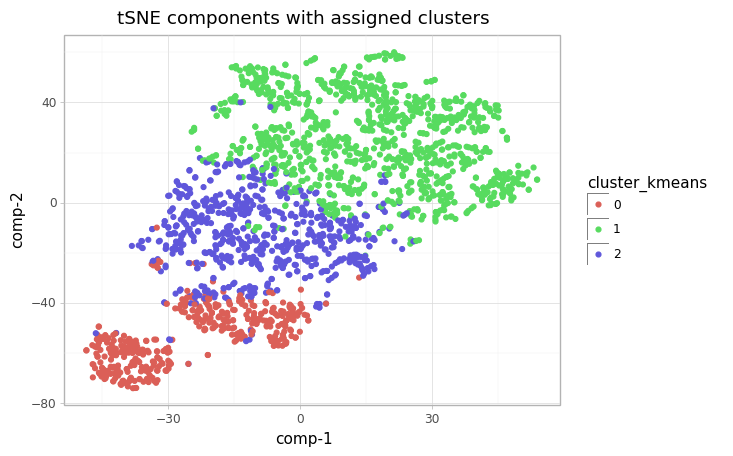

<ggplot: (130907944903)>

In [22]:
(ggplot(df_tSNE) + 
 geom_point(aes(x = "comp-1", y = "comp-2", color = "cluster_kmeans")) + 
 ggtitle("tSNE components with assigned clusters") + 
 theme_light())